In [1]:
import pyforest
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime,timedelta
from pylab import rcParams
from IPython.display import display
from statsmodels.tsa.stattools import acf,pacf,adfuller,coint
from statsmodels.graphics.tsaplots import plot_pacf,plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.gofplots import  qqplot
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.api import ExponentialSmoothing,VAR
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error,mean_absolute_percentage_error


import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
df=pd.read_csv('train.csv')

In [3]:
dates = pd.date_range(start='1749-01-01', end='2010-12-01', freq='MS')

In [4]:
df['timeStamp']=pd.DataFrame(dates)

In [5]:
df.drop('Month',axis=1,inplace=True)


In [6]:
df

,Avg_sunspot_count,timeStamp
0,97,1749-01-01
1,104,1749-02-01
2,117,1749-03-01
3,93,1749-04-01
4,142,1749-05-01
...,...,...
3139,30,2010-08-01
3140,36,2010-09-01
3141,34,2010-10-01
3142,34,2010-11-01


In [7]:
df.isna().sum()
df.isnull().sum()

Avg_sunspot_count    0
timeStamp            0
dtype: int64

<Axes: >

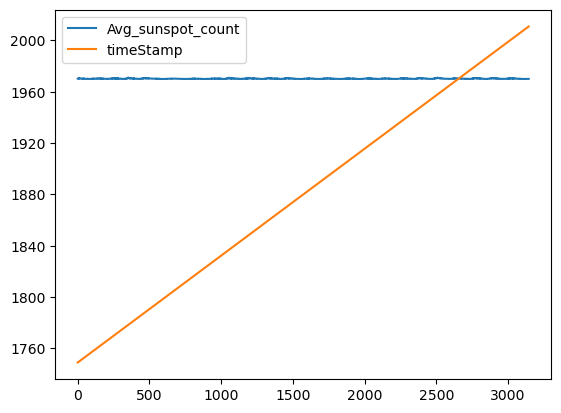

In [13]:
# no null values
df.plot()

In [14]:
df.head()

,Avg_sunspot_count,timeStamp
0,97,1749-01-01
1,104,1749-02-01
2,117,1749-03-01
3,93,1749-04-01
4,142,1749-05-01


In [33]:
df.dtypes
import matplotlib.pyplot as plt
df

,Avg_sunspot_count
timeStamp,
1749-01-01,97
1749-02-01,104
1749-03-01,117
1749-04-01,93
1749-05-01,142
...,...
2010-08-01,30
2010-09-01,36
2010-10-01,34


AttributeError: 'DataFrame' object has no attribute 'timeStamp'

In [23]:
df.dtypes

Avg_sunspot_count             int64
timeStamp            datetime64[ns]
dtype: object

In [27]:
df.set_index('timeStamp',inplace=True)


<Figure size 20000x1500 with 0 Axes>

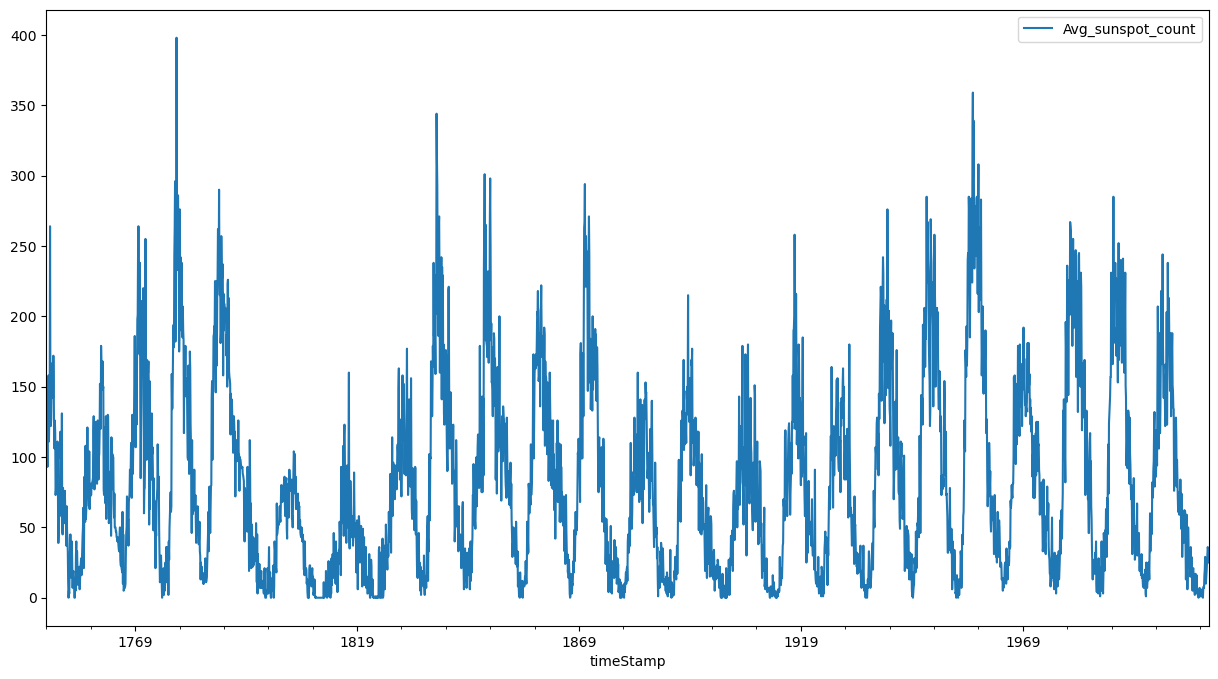

In [41]:
plt.figure(figsize=(200,15))
df.plot(figsize=(15,8));


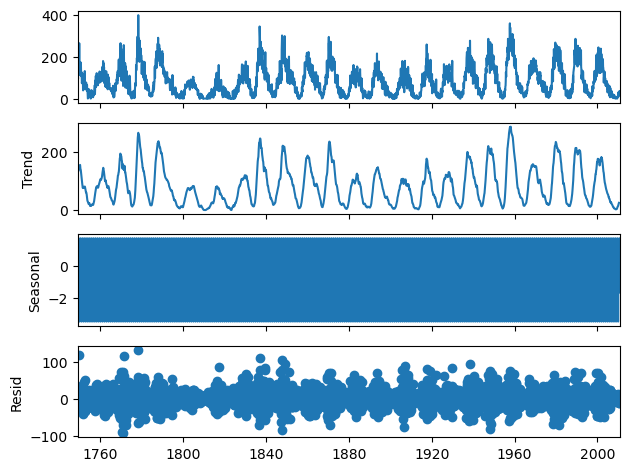

In [28]:
decomposition = seasonal_decompose(df,model='additive')
decomposition.plot();
#multiplicative notgoodfor zero values

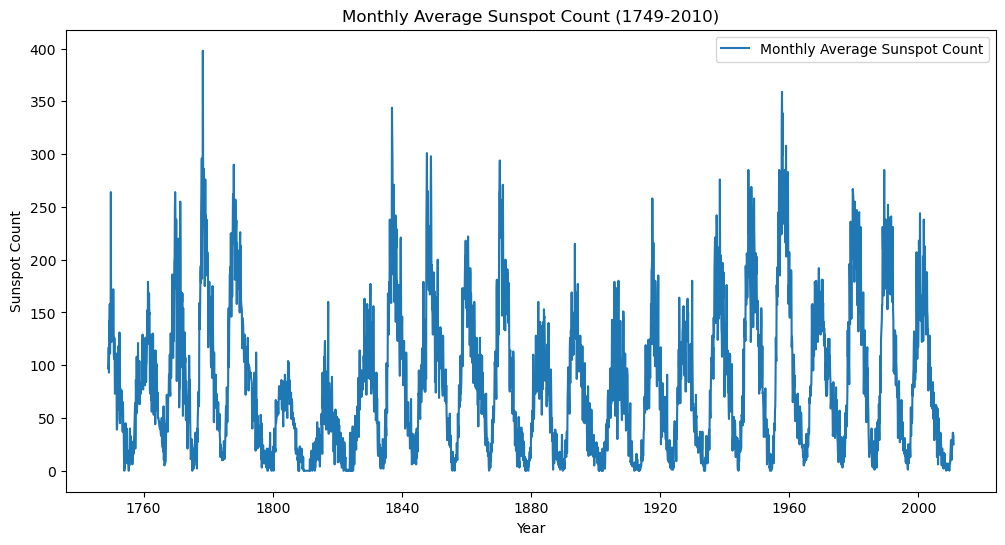

In [48]:
plt.figure(figsize=(12, 6))
plt.plot(df, label='Monthly Average Sunspot Count')
plt.title('Monthly Average Sunspot Count (1749-2010)')
plt.xlabel('Year')
plt.ylabel('Sunspot Count')
plt.legend()
plt.show()

In [49]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Splitting the data into training and testing sets
train_data = df[:'2010-12-01']

# Defining the SARIMA model
model = SARIMAX(train_data, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
sarima_model = model.fit(disp=False)

# Displaying the model summary
sarima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                  Avg_sunspot_count   No. Observations:                 3144
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood              -14610.102
Date:                            Sun, 09 Jun 2024   AIC                          29230.203
Time:                                    20:53:31   BIC                          29260.449
Sample:                                01-01-1749   HQIC                         29241.059
                                     - 12-01-2010                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2254      0.027      8.491      0.000       0.173       0.277
ma.L1         -0.6527      0.021    -31.272      0.000      -0.694      -0.612
ar.S.L12       0.0548      0.015      3.758      0.000       0.026       0.083
ma.S.L12      -0.9969      0.011    -87.934      0.000      -1.019      -0.975
sigma2       649.4427     12.151     53.449      0.000     625.628     673.258
===================================================================================
Ljung-Box (L1) (Q):                   0.20   Jarque-Bera (JB):              1018.40
Prob(Q):                              0.65   Prob(JB):                         0.00
Heteroskedasticity (H):               1.02   Skew:                             0.33
Prob(H) (two-sided):                  0.72   Kurtosis:                         5.72
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

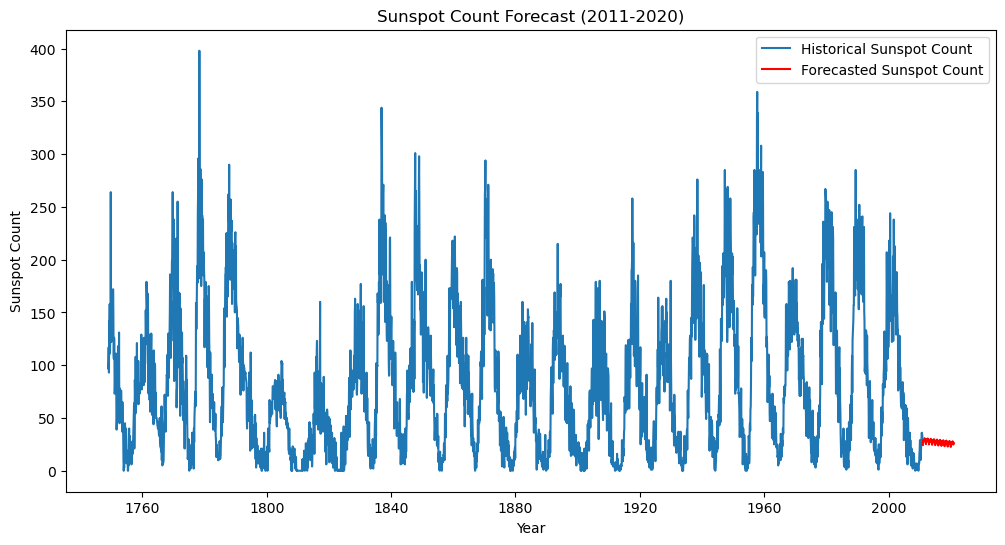

In [52]:
forecast = sarima_model.get_forecast(steps=120)
forecast_index = pd.date_range(start='2011-01-01', end='2020-12-01', freq='MS')
forecast_df = pd.DataFrame({'Forecast': forecast.predicted_mean}, index=forecast_index)

# Plotting the forecast
plt.figure(figsize=(12, 6))
plt.plot(df, label='Historical Sunspot Count')
plt.plot(forecast_df, label='Forecasted Sunspot Count', color='red')
plt.title('Sunspot Count Forecast (2011-2020)')
plt.xlabel('Year')
plt.ylabel('Sunspot Count')
plt.legend()
plt.show()

forecast_df.to_csv('forcast.csv')

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import itertools

# Define the p, d, and q parameters to take any value between 0 and 2
p = d = q = range(0, 3)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in pdq]

best_aic = float("inf")
best_params = None
best_seasonal_params = None

for param in pdq:
    for seasonal_param in seasonal_pdq:
        try:
            mod = SARIMAX(train_data,
                          order=param,
                          seasonal_order=seasonal_param,
                          enforce_stationarity=False,
                          enforce_invertibility=False)

            results = mod.fit(disp=False)

            if results.aic < best_aic:
                best_aic = results.aic
                best_params = param
                best_seasonal_params = seasonal_param
        except:
            continue

print(f'Best SARIMA parameters: {best_params} x {best_seasonal_params} with AIC: {best_aic}')

In [ ]:
# Training the best model found
best_model = SARIMAX(train_data, order=best_params, seasonal_order=best_seasonal_params, enforce_stationarity=False, enforce_invertibility=False)
best_model_fit = best_model.fit(disp=False)

# Displaying the model summary
best_model_fit.summary()


In [ ]:
forecast = best_model_fit.get_forecast(steps=len(test_data))
forecast_index = test_data.index
forecast_df = pd.DataFrame({'Forecast': forecast.predicted_mean}, index=forecast_index)

# Calculating RMSE
rmse = np.sqrt(mean_squared_error(test_data, forecast_df))
print(f'RMSE: {rmse}')

# Plotting the results
plt.figure(figsize=(12, 6))
plt.plot(train_data, label='Training Data')
plt.plot(test_data, label='Actual Data')
plt.plot(forecast_df, label='Forecasted Data', color='red')
plt.title('Sunspot Count Forecast')
plt.xlabel('Year')
plt.ylabel('Sunspot Count')
plt.legend()
plt.show()